# Developer Guide

This page is dedicated to developers who want to contribute to the ADAPT library.

The guide is divided is three parts:

- Opening a pull request in ADAPT
- Implementing a new Domain Adaptation method
- Contributing to the documentation

## 1. Opening a pull request in ADAPT

First go on GitHub at https://github.com/adapt-python/adapt and fork the repository:

<img src="../_static/images/fork.png" alt="fork">

On your labtop, open a command prompt and clone your fork with the following command line:

`git clone https://github.com/<your GitHub name>/adapt.git`

Or:

`git clone git@github.com:<your GitHub name>/adapt.git`

Make changes in the cloned repository on your labtop. When you have finished, commit your changes and push them to your GitHub fork with the following command lines:

`git add .`

`git commit -m "My changes"`

`git push`

Finally,open a pull request on the main repository by selecting "Contribute" and "Open pull request" on your GitHub fork:

<img src="../_static/images/contribute.png" alt="contribute">

You can give a title to your pull request and a description of your changes. Your pull request will be reviewed and merged to the main repository if your code complies with the ADAPT library.

## 2. Implementing a new Domain Adaptation method

This part explains how to implement a novel DA method in the ADAPT style. Your implementation can be done in the cloned repository on your labtop (see previous part).

### 2.1 Implementing a classic DA method

If your proposed approach does not use deep learning, you should subclass the `BaseAdaptEstimator` object.

Let's say you want to develop a simple feature-based approach which learns the PCA of the source domain and applies it to the target domain. The only thing you have to do is to implement the `__init__`, `transform` and `fit_transform` methods.

In [22]:
from adapt.base import BaseAdaptEstimator
from sklearn.decomposition import PCA


class SrcPCA(BaseAdaptEstimator):
    # Write a description of the algorithm, parameters and attributes.
    """
    SrcPCA : Source PCA
    
    SrcPCA learns the PCA on the source domain and applies it on the
    target domain
    
    Parameters
    ----------
    estimator : sklearn estimator or Tensorflow Model
        The task estimator.
        
    Xt : array
        The target input data.
        
    n_components : int (default=2)
        Number of principal components
        
    Attributes
    ----------
    estimator_ : sklearn estimator or Tensorflow Model
        The fitted estimator
    """
    
    
    def __init__(self,
                 estimator=None,
                 Xt=None,
                 n_components=2):
        
        super().__init__(
            estimator=estimator,
            Xt=Xt
        )
        self.n_components = n_components
        
    
    def fit_transform(self, Xs, Xt, **kwargs):
        """
        Fit embeddings.
        
        Parameters
        ----------
        Xs : array
            Input source data.
            
        Xt : array
            Input target data.
                        
        kwargs : key, value argument
            Not used, present here for adapt consistency.
            
        Returns
        -------
        Xs_emb : embedded source data
        """
        
        self.pca_ = PCA(self.n_components)
        Xs_emb = self.pca_.fit_transform(Xs)
        
        return Xs_emb
    
    
    def transform(self, X, **kwargs):
        """
        Return aligned features for X.
        
        Parameters
        ----------
        X : array
            Input data.
            
        Returns
        -------
        X_emb : array
            Embeddings of X.
        """
        
        return self.pca_.transform(X)

You can now test your method on a simple case. For example you can use the `make_classification_da` function from [adapt.utils](https://adapt-python.github.io/adapt/contents.html#adapt-utils)

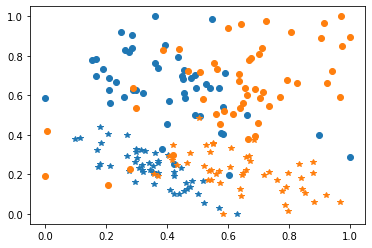

In [42]:
from adapt.utils import make_classification_da
import matplotlib.pyplot as plt

Xs, ys, Xt, yt = make_classification_da()
plt.plot(Xs[ys==1, 0], Xs[ys==1, 1], "o", c="C0")
plt.plot(Xs[ys==0, 0], Xs[ys==0, 1], "*", c="C0")
plt.plot(Xt[yt==1, 0], Xt[yt==1, 1], "o", c="C1")
plt.plot(Xt[yt==0, 0], Xt[yt==0, 1], "*", c="C1")
plt.show()

Take one estimator from sklearn and test your novel DA algorithm. Note that the `fit` and `score` methods will call your implemented `fit_transform` and `transform` methods.

In [41]:
from sklearn.linear_model import LogisticRegression

model = SrcPCA(LogisticRegression(penalty="none"), Xt=Xt, n_components=1)
model.fit(Xs, ys)
print("Score: %.3f"%model.score(Xt, yt))

Fit transform...
Fit Estimator...
Score: 0.930


Now, add your source code for `SrcPCA` to a file named `_srcpca.py` that you place in the adapt/feature_based folder. Modify the `__init__.py` file in the folder to add your method in the `__all__` list.

Finally, you have to create a test file to perform some unit tests on your method. For this, create a file named `test_scrpca.py` in the tests folder. In this file, you can write the following code for example:

In [ ]:
from adapt.feature_based import SrcPCA
from adapt.utils import make_classification_da
from sklearn.linear_model import LogisticRegression

def test_srcpca():
    Xs, ys, Xt, yt = make_classification_da()
    model = SrcPCA(LogisticRegression(penalty="none"), Xt=Xt, n_components=1)
    model.fit(Xs, ys)
    score = model.score(Xt, yt)

If you want to be sure that your tests are working, you can install the `pytest` package and run the tests:

`pip install pytest pytest-cov`

In the adapt folder

`pytest tests/test_srcpca.py`

### 2.2 Implementing a deep DA method

If your proposed approach is deep learning specific, you should subclass the `BaseAdaptDeep` object.

Let's say you want to develop a feature-based approach which learns a deep representation where the source and target domains are both centered with variance close to one. The only think you have to do is to implement the `__init__` and `train_step` methods.

In [99]:
import tensorflow as tf
from adapt.base import BaseAdaptDeep


class CenterDomains(BaseAdaptDeep):
    # Write a description of the algorithm, parameters and attributes.
    """
    CenterDomains : Centering domains
    
    CenterDomains learns a deep representation where the source and target domains
    are both centered with variance close to one.
    
    Parameters
    ----------
    encoder : tensorflow Model (default=None)
        Encoder netwok.
        
    task : tensorflow Model (default=None)
        Task netwok.
        
    Xt : array
        Target input data.
        
    lambda_ : float (default=1.)
        Trade-off between task and domain closeness.
        
    Attributes
    ----------
    encoder_ : tensorflow Model
        Fitted encoder network.
        
    task_ : tensorflow Model
        Fitted task network.
    """
    
    
    def __init__(self,
                 encoder=None,
                 task=None,
                 lambda_=1.,
                 Xt=None):
        
        super().__init__(
            encoder=encoder,
            task=task,
            Xt=Xt
        )
        self.lambda_ = lambda_
        
    
    def train_step(self, data):
        # Unpack the data.
        Xs, Xt, ys, yt = self._unpack_data(data)
       
        # loss
        with tf.GradientTape() as task_tape, tf.GradientTape() as enc_tape:
            # Forward pass
            Xs_enc = self.encoder_(Xs, training=True)
            ys_pred = self.task_(Xs_enc, training=True)
            
            Xt_enc = self.encoder_(Xt, training=True)
            
            # Reshape
            ys_pred = tf.reshape(ys_pred, tf.shape(ys))
            
            # Compute the loss value
            task_loss = self.task_loss_(ys, ys_pred)
            
            mean_src = tf.reduce_mean(Xs_enc, axis=0)
            var_src = tf.math.reduce_variance(Xs_enc, axis=0)
            mean_tgt = tf.reduce_mean(Xt_enc, axis=0)
            var_tgt = tf.math.reduce_variance(Xt_enc, axis=0)
            
            enc_loss = tf.square(mean_src) + tf.square(mean_tgt)
            enc_loss += tf.square(1-var_src) + tf.square(1-var_tgt)
            
            task_loss = tf.reduce_mean(task_loss)
            enc_loss = tf.reduce_mean(enc_loss)
            
            enc_loss = task_loss + self.lambda_ * enc_loss
            
            task_loss += sum(self.task_.losses)
            enc_loss += sum(self.encoder_.losses)
            
            
        # Compute gradients
        trainable_vars_task = self.task_.trainable_variables
        trainable_vars_enc = self.encoder_.trainable_variables
        
        gradients_task = task_tape.gradient(task_loss, trainable_vars_task)
        gradients_enc = enc_tape.gradient(enc_loss, trainable_vars_enc)
        
        # Update weights
        self.optimizer.apply_gradients(zip(gradients_task, trainable_vars_task))
        self.optimizer_enc.apply_gradients(zip(gradients_enc, trainable_vars_enc))
        
        # Update metrics
        self.compiled_metrics.update_state(ys, ys_pred)
        self.compiled_loss(ys, ys_pred)
        # Return a dict mapping metric names to current value
        logs = {m.name: m.result() for m in self.metrics}
        return logs

You can now test your method on a simple case. For example you can use the `make_classification_da` function from [adapt.utils](https://adapt-python.github.io/adapt/contents.html#adapt-utils)

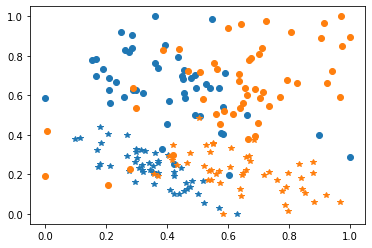

In [100]:
from adapt.utils import make_classification_da
import matplotlib.pyplot as plt

Xs, ys, Xt, yt = make_classification_da()
plt.plot(Xs[ys==1, 0], Xs[ys==1, 1], "o", c="C0")
plt.plot(Xs[ys==0, 0], Xs[ys==0, 1], "*", c="C0")
plt.plot(Xt[yt==1, 0], Xt[yt==1, 1], "o", c="C1")
plt.plot(Xt[yt==0, 0], Xt[yt==0, 1], "*", c="C1")
plt.show()

Create simple neural networks and test your novel deep DA algorithm.

In [102]:
encoder = tf.keras.Sequential()
encoder.add(tf.keras.layers.Dense(100, activation="relu"))
encoder.add(tf.keras.layers.Dense(2))

task = tf.keras.Sequential()
task.add(tf.keras.layers.Dense(1, activation="sigmoid"))

model = CenterDomains(encoder=encoder,
                      task=task,
                      Xt=Xt,
                      lambda_=1.)
model.compile(loss="binary_crossentropy", optimizer="adam")
model.fit(Xs, ys, epochs=100, verbose=0)
print("Score: %.3f"%model.score(Xt, yt))

1/1 [==============================] - 0s 118ms/step - loss: 0.2461
Score: 0.246


You can also check that your encoded space behave as expected

In [106]:
Xs_enc = model.transform(Xs)
Xt_enc = model.transform(Xt)

print(Xs_enc.mean(0), Xt_enc.mean(0))
print(Xs_enc.var(0), Xt_enc.var(0))

[-0.02707285  0.00268192] [-0.03096193 -0.06729582]
[0.9326022 0.9280451] [1.08319   1.0991981]


Finally, follow the instructions in 2.1 to add your implementation in the adapt folder and make the tests.

## 3. Contributing to the documentation

If you want to add examples of ADAPT usage to the documentation, this can be done by modifying the `src_docs` folder.

First, install all the packages you need for documentation:

`sudo apt install pandoc` or `conda install pandoc`

And,

`pip install jinja2==3.0.3 sphinx==4.4.0 numpydoc==1.2 nbsphinx==0.8.8 sphinx_gallery==0.10.1 sphinx_rtd_theme==1.0.0 ipython==8.0.1`

Then, make your example in a jupyter notebook and add it to the `src_docs/examples` folder

To make your example appear in the content page, add the path to your example in either `src_docs/synthetic_examples.rst` or `src_docs/real_examples.rst` file depending on which kind of example you have made.

You can check the rendering of your example by compiling the documentation with the following command line (executed in the adapt folder):

`make html`

You can now open the folder `docs/html/` you will find a file named `contents.html`. When you open this file you will find the path to your example in the examples sections.